In [1]:
# Allows us to import packages that exist one level up in the file system
# See https://stackoverflow.com/questions/34478398
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tagnews.utils import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
df = ld.load_data()

/home/kevin/miniconda3/envs/cjp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Article Tags Exploration

In [7]:
print('Number total articles   :', df.shape[0])
print('Number tagged articles  :', df.loc[:, 'OEMC':'TASR'].any(1).sum() + (~df['relevant']).sum())

# this number should be 0, but it isn't...
print('# articles tagged but not relevant :', (~df['relevant'] & df.loc[:, 'OEMC':'TASR'].any(1)).sum())

Number total articles   : 271808
Number tagged articles  : 196703
# articles tagged but not relevant : 2733


In [8]:
categories_df = ld.load_categories()
categories_df = categories_df.loc[:, ['abbreviation', 'category_name']]
categories_df.set_index('abbreviation', drop=True, inplace=True)

categories_df['counts'] = df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True)
categories_df.sort_values(by='counts')

,category_name,counts
abbreviation,,
ENVI,Environmental Crimes,49
TASR,Police Use of Taser,119
OEMC,Office of Emergency Management & Communications,127
REEN,Re-Entry,129
CPBD,Chicago Police Board,155
ILSC,Illinois State Court,179
IMMG,Immigration,218
CPUB,Cook County Public Defender's Office,222
IDOC,Illinois Department of Corrections,300


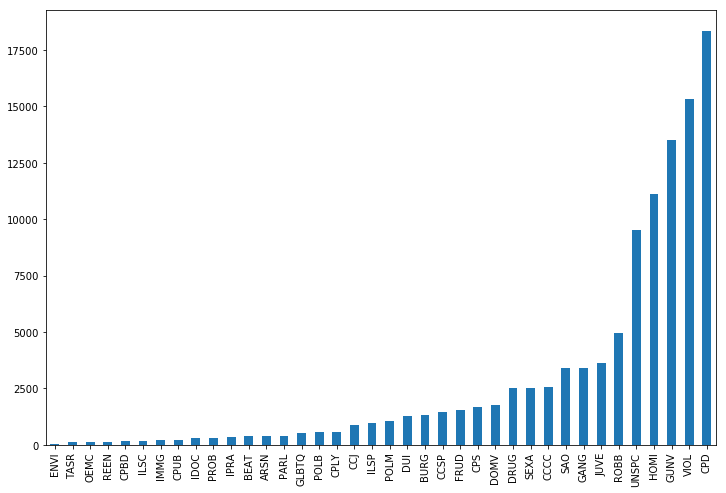

In [10]:
df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True).sort_values().plot(kind='bar');

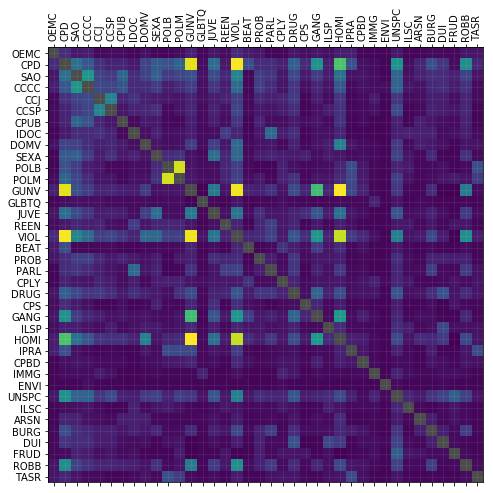

In [11]:
corrs = df.loc[:, 'OEMC':'TASR'].corr()
for i in range(corrs.shape[0]):
    corrs.iloc[i, i] = np.nan

cmap = matplotlib.cm.viridis
cmap.set_bad((.3, .3, .3),1.)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.ma.masked_invalid(corrs.values), cmap=cmap)

ax.grid(True, color=(.9, .9, .9), alpha=.1)

plt.xticks(range(len(corrs.columns)), corrs.columns, rotation=90);
plt.yticks(range(len(corrs.columns)), corrs.columns);

# Text Contents Exploration

In [12]:
# Print a random article just to see what they look like.
i = np.random.choice(df.shape[0])
print('ARTICLE ID:', df.index[i], '\n------------------')
print(df.iloc[i]['bodytext'])

ARTICLE ID: 126531 
------------------
##  Breaking Bad Finale Review

![][1]

[ Tweet ][2]

By  Devin Mainville  , September 29, 2013 at 11:10 pm

![Breaking Bad Finale Review][3]

** Spoiler Alert: Do not read if you haven’t seen the _ Breaking Bad _ series fi
nale entitled “Felina”. **

_ “I did it for me. I liked it. I was good at it. I was really… I was alive.”
– Walter White _

Vince Gilligan promised us a satisfying ending and, as usual, he delivered.
There were no lingering questions or loose strings. Not only was everything
answered, but it also placated everyone. For those who wanted Walt to succeed,
he did, he made enough money to help his family and actually managed to get
the money to them. For those who wanted Walt to die, well he did that too.

There was never a scenario where Walt wouldn’t die. Even if the closing shot
had been him sipping a margarita in Mexico and counting his millions his
cancer would still be there. The show could have ended in any way, but from
the 

## Some questions:

* How to handle articles that talk about more than one crime (i.e. a summary of weekend violence)?
* Would we want the scraper to keep any more information going forward? Author name, for example?
* Do we want to have manually-defined cleaning built around the format? I.e. specifically remove the links at the bottom that are result of RSS format? 

In [13]:
import nltk
# you may need to run nltk.download()
# and get the "punkt" dataset under the "Models" tab
# to use the word_tokenize function. Other models might
# be necessary as well.

In [14]:
def all_words():
    counter = 0
    for txt in df['bodytext']:
        tokens = nltk.tokenize.word_tokenize(txt)
        for t in tokens:
            if t[0] not in '[](){},.\'"`*:;/\\-+=_':
                yield t.lower()
                counter += 1
            if counter > 5e6: # at some point will need to run fully, but truncate for now
                return

In [15]:
word_freqs = nltk.FreqDist(all_words())

"the": 229843
"to": 115787
"a": 111580
"and": 107410
"of": 96346
"in": 86582
"that": 44345
"for": 40958
"was": 40470
"said": 38846
"on": 34827
"he": 34234
"is": 30465
"with": 28751
"http": 26944
"at": 26815
"it": 26757
"his": 23698
"1": 22834
"2": 22318
"i": 21964
"as": 20555
"by": 20505
"3": 19494
"from": 18430
"be": 18401
"#": 18345
"this": 18178
"4": 18035
"not": 16950
"5": 16806
"have": 16678
"but": 16231
"chicago": 15932
"an": 15851
"’": 15706
"they": 15564
"police": 15522
"6": 15274
"who": 15085


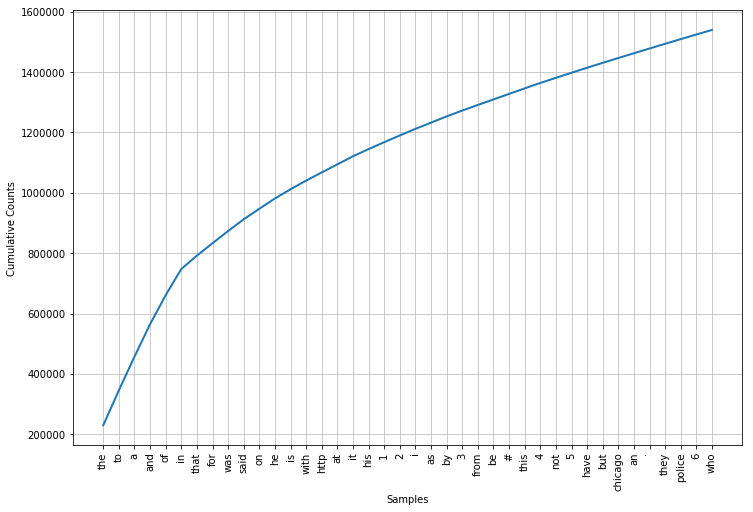

In [16]:
for pair in word_freqs.most_common(40):
    print('"{}": {}'.format(pair[0], pair[1]))
word_freqs.plot(40, cumulative=True)

In [17]:
print('The word "the" is {0:.4} times more common than "gun".'.format(
    word_freqs.freq('the') / word_freqs.freq('gun')
))

The word "the" is 173.3 times more common than "gun".


In [18]:
print('Confusion matrix using existence of "gun" to predict "GUNV" tag:')
pd.crosstab(df['bodytext'].str.contains('gun'), df['GUNV'])

Confusion matrix using existence of "gun" to predict "GUNV" tag:


GUNV,0,1
bodytext,,
False,238193,4347
True,20121,9147
